<a href="https://colab.research.google.com/github/rondinell/Intelig-ncia-Artificial/blob/main/Orientador_de_compra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-1931497304>:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(ativo, start=data_inicio, end=data_fim)
[*********************100%***********************]  1 of 1 completed


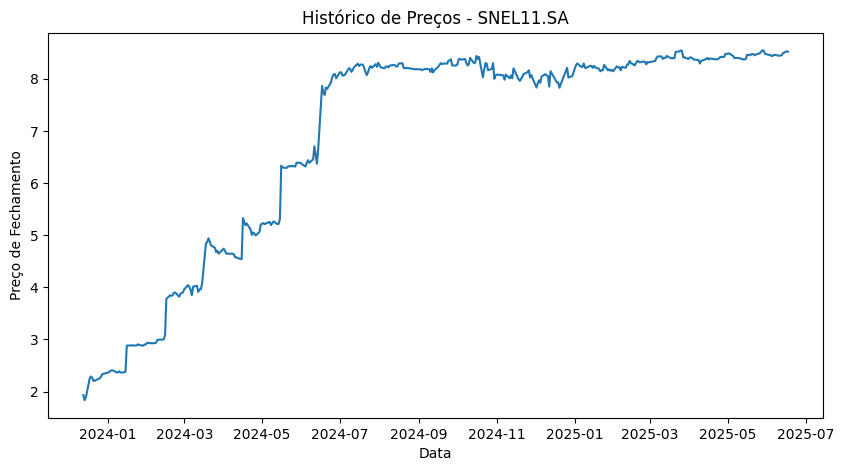

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - loss: 0.4869
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0631
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.0551
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0095
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0150
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - loss: 0.0111
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0080
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0067
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0048
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0051
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0054
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0068
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0047
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - loss: 0.0046
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - loss: 0.0051
Epoch 16/20
5/5 ━━━━━━━━━━━━━━

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
RMSE: 0.15


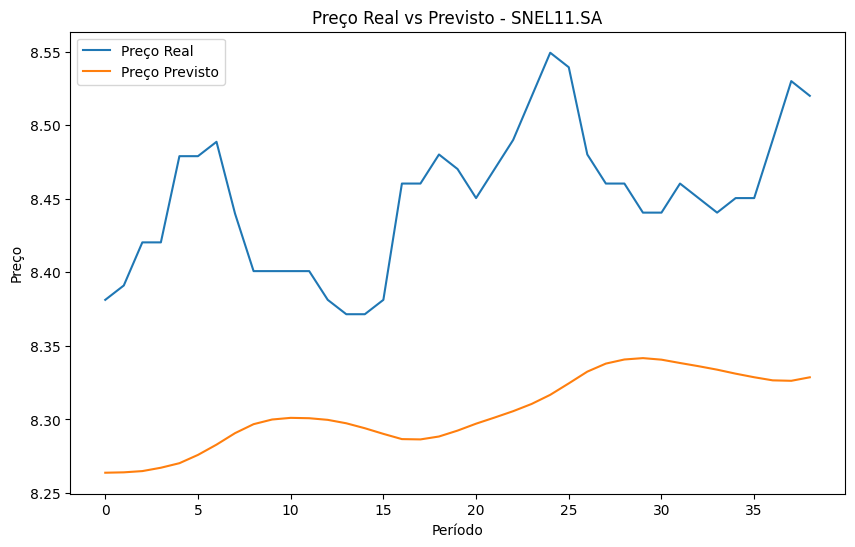

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Preço atual: R$ 8.52
Preço previsto para o próximo dia: R$ 8.33
Recomendação: NÃO COMPRA ❌


In [3]:
# Instalar bibliotecas necessárias
!pip install yfinance ta scikit-learn tensorflow --quiet

# Importar bibliotecas
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import math

# Escolher o ativo
ativo = "SNEL11.SA"  # Altere para o ativo desejado

# Baixar dados dos últimos 5 anos
data_inicio = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')
data_fim = datetime.today().strftime('%Y-%m-%d')
dados = yf.download(ativo, start=data_inicio, end=data_fim)

# Verificar dados
dados = dados[['Close']].dropna()
plt.figure(figsize=(10,5))
plt.title(f'Histórico de Preços - {ativo}')
plt.plot(dados['Close'])
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.show()

# Normalizar os preços
scaler = MinMaxScaler(feature_range=(0, 1))
precos_normalizados = scaler.fit_transform(dados['Close'].values.reshape(-1, 1))

# Criar sequências de 182 dias
def criar_dados(dados, janela=182):
    X, y = [], []
    for i in range(janela, len(dados)):
        X.append(dados[i-janela:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

X, y = criar_dados(precos_normalizados)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Separar em treino e teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Construir modelo LSTM
modelo = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

modelo.compile(optimizer='adam', loss='mean_squared_error')

# Treinar modelo
modelo.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Fazer previsões no conjunto de teste
previsao = modelo.predict(X_test)
previsao = scaler.inverse_transform(previsao.reshape(-1,1))
y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

# Avaliar o modelo
rmse = math.sqrt(mean_squared_error(y_test_real, previsao))
print(f'RMSE: {rmse:.2f}')

# Plotar resultados
plt.figure(figsize=(10,6))
plt.plot(y_test_real, label='Preço Real')
plt.plot(previsao, label='Preço Previsto')
plt.title(f'Preço Real vs Previsto - {ativo}')
plt.xlabel('Período')
plt.ylabel('Preço')
plt.legend()
plt.show()

# Fazer previsão para o próximo dia
ultimo_intervalo = precos_normalizados[-182:]
entrada = ultimo_intervalo.reshape(1, 182, 1)
preco_previsto = modelo.predict(entrada)
preco_previsto = scaler.inverse_transform(preco_previsto)[0][0]
preco_atual = dados['Close'].values[-1]

print(f'Preço atual: R$ {preco_atual.item():.2f}')
print(f'Preço previsto para o próximo dia: R$ {preco_previsto:.2f}')

# Critério de decisão
if preco_previsto >= preco_atual * 1.02:
    print("Recomendação: COMPRA ✅")
else:
    print("Recomendação: NÃO COMPRA ❌")